In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return result

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return result

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = 0, xmax = 0):
    plt.grid(True)
    plt.plot(x, y, "o")
    k, b = mnk_non_zero(x, y)
    xl = np.array([min(x.min(), xmin), max(xmax, x.max())])
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

def linearcalc_error(x, y, xmin = 0, xmax = 0):
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
    else:
        y_value = y
        y_error = [0]*len(y_error)
    k, b = mnk_non_zero(x_value, y_value)

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1)
    
    xl = np.array([min(x_value.min(), xmin), max(xmax, x_value.max())])
    plt.errorbar(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
        
    
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))



<>:190: SyntaxWarning: invalid escape sequence '\p'
<>:193: SyntaxWarning: invalid escape sequence '\p'
<>:195: SyntaxWarning: invalid escape sequence '\p'
<>:195: SyntaxWarning: invalid escape sequence '\c'
<>:198: SyntaxWarning: invalid escape sequence '\p'
<>:190: SyntaxWarning: invalid escape sequence '\p'
<>:193: SyntaxWarning: invalid escape sequence '\p'
<>:195: SyntaxWarning: invalid escape sequence '\p'
<>:195: SyntaxWarning: invalid escape sequence '\c'
<>:198: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_10174/1726036329.py:190: SyntaxWarning: invalid escape sequence '\p'
  return f"${value_str} \pm {delta_str}$"
/tmp/ipykernel_10174/1726036329.py:193: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str}")
/tmp/ipykernel_10174/1726036329.py:195: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
/tmp/ipykernel_10174/1726036329.py:195: SyntaxWarning: invalid escape sequence '\c'
  ret

In [63]:
p_spirt_s = pd.Series([42, 42, 41, 42, 42, 42, 42, 42])
p_spirt_s = p_spirt_s.apply(lambda x: DData(x, 1))
p_spirt = SerDData(p_spirt_s).mean * 0.2 * 9.81
sigma_spirt = DData(22.7, 0.1, E = -3)
R = 2*sigma_spirt/p_spirt
R.E = 0
print(R)

$0.000553 \pm 0.000013$


In [64]:
P_1 = pd.Series([129, 128, 129, 130, 130])
P_2 = pd.Series([180, 181, 182, 181, 181])
P_1 = P_1.apply(lambda x: DData(x, 1))
P_2 = P_2.apply(lambda x: DData(x, 1))
dP = (SerDData(P_2).mean - SerDData(P_1).mean)*9.81*0.2
print(dP)

$101.6 \pm 2.8$


In [65]:
P_T = pd.DataFrame()
P_T[22] = pd.Series([180, 181, 182, 181, 181, 182])
P_T[25] = pd.Series([180, 179, 179, 179, 179, 179])
P_T[30] = pd.Series([178, 178, 178, 178, 178, 178])
P_T[35] = pd.Series([176, 177, 177, 176, 177, 176])
P_T[40] = pd.Series([176, 175, 175, 175, 175, 175])
P_T[45] = pd.Series([174, 174, 174, 173, 173, 172])
P_T[50] = pd.Series([173, 172, 172, 173, 172, 172])
P_T[55] = pd.Series([172, 172, 179, 171, 170, 171])

for T in P_T.columns:
    P_T[T] = P_T[T].apply(lambda x: DData(x, 1))

P_T

,22,25,30,35,40,45,50,55
0,$180.0 \pm 1.0$,$180.0 \pm 1.0$,$178.0 \pm 1.0$,$176.0 \pm 1.0$,$176.0 \pm 1.0$,$174.0 \pm 1.0$,$173.0 \pm 1.0$,$172.0 \pm 1.0$
1,$181.0 \pm 1.0$,$179.0 \pm 1.0$,$178.0 \pm 1.0$,$177.0 \pm 1.0$,$175.0 \pm 1.0$,$174.0 \pm 1.0$,$172.0 \pm 1.0$,$172.0 \pm 1.0$
2,$182.0 \pm 1.0$,$179.0 \pm 1.0$,$178.0 \pm 1.0$,$177.0 \pm 1.0$,$175.0 \pm 1.0$,$174.0 \pm 1.0$,$172.0 \pm 1.0$,$179.0 \pm 1.0$
3,$181.0 \pm 1.0$,$179.0 \pm 1.0$,$178.0 \pm 1.0$,$176.0 \pm 1.0$,$175.0 \pm 1.0$,$173.0 \pm 1.0$,$173.0 \pm 1.0$,$171.0 \pm 1.0$
4,$181.0 \pm 1.0$,$179.0 \pm 1.0$,$178.0 \pm 1.0$,$177.0 \pm 1.0$,$175.0 \pm 1.0$,$173.0 \pm 1.0$,$172.0 \pm 1.0$,$170.0 \pm 1.0$
5,$182.0 \pm 1.0$,$179.0 \pm 1.0$,$178.0 \pm 1.0$,$176.0 \pm 1.0$,$175.0 \pm 1.0$,$172.0 \pm 1.0$,$172.0 \pm 1.0$,$171.0 \pm 1.0$


In [66]:
Ts = P_T.columns
Ps = []
for T in Ts:
    p = SerDData(P_T[T]).mean
    Ps.append(p)
Ps = pd.Series(Ps)

raschet = pd.DataFrame()
raschet["T"] = Ts
raschet["T"] = raschet["T"].apply(lambda x: DData(x, 0.2))
raschet["P_0"] = Ps
raschet["P"] = Ps*0.2*9.81-dP
raschet["sigma"] = raschet["P"] * R / 2
DData.changeEInSerias(raschet["sigma"], -3)
raschet


,T,P_0,P,sigma
0,$22.00 \pm 0.20$,$181.2 \pm 1.0$,$253.8 \pm 3.4$,$70.1 \pm 2.0$
1,$25.00 \pm 0.20$,$179.2 \pm 1.0$,$249.9 \pm 3.4$,$69.0 \pm 1.9$
2,$30.00 \pm 0.20$,$178.0 \pm 1.0$,$247.6 \pm 3.4$,$68.4 \pm 1.9$
3,$35.00 \pm 0.20$,$176.5 \pm 1.0$,$244.7 \pm 3.4$,$67.6 \pm 1.9$
4,$40.00 \pm 0.20$,$175.2 \pm 1.0$,$242.0 \pm 3.4$,$66.9 \pm 1.9$
5,$45.00 \pm 0.20$,$173.3 \pm 1.0$,$238.4 \pm 3.4$,$65.9 \pm 1.9$
6,$50.00 \pm 0.20$,$172.3 \pm 1.0$,$236.5 \pm 3.4$,$65.3 \pm 1.8$
7,$55.00 \pm 0.20$,$172.5 \pm 1.1$,$236.8 \pm 3.6$,$65.4 \pm 1.9$


k, b = $-0.146 \pm 0.012$ $72.86 \pm 0.48$


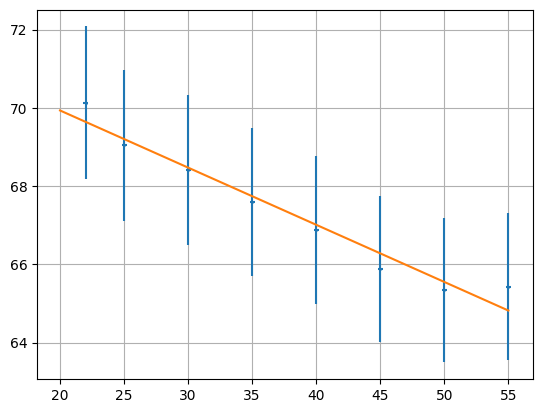

In [67]:
k, _ = linearcalc_error(raschet["T"], raschet["sigma"], 20)

In [68]:
k = k/10**3
k.E = 0
raschet["q"] = -(raschet["T"]+273.15)*k
raschet["U"] = raschet["sigma"] + raschet["q"]
DData.changeEInSerias(raschet["U"], -3)
DData.changeEInSerias(raschet["q"], -3)
raschet

,T,P_0,P,sigma,q,U
0,$22.00 \pm 0.20$,$181.2 \pm 1.0$,$253.8 \pm 3.4$,$70.1 \pm 2.0$,$43.1 \pm 3.6$,$113.3 \pm 4.1$
1,$25.00 \pm 0.20$,$179.2 \pm 1.0$,$249.9 \pm 3.4$,$69.0 \pm 1.9$,$43.6 \pm 3.6$,$112.6 \pm 4.1$
2,$30.00 \pm 0.20$,$178.0 \pm 1.0$,$247.6 \pm 3.4$,$68.4 \pm 1.9$,$44.3 \pm 3.7$,$112.7 \pm 4.2$
3,$35.00 \pm 0.20$,$176.5 \pm 1.0$,$244.7 \pm 3.4$,$67.6 \pm 1.9$,$45.0 \pm 3.8$,$112.6 \pm 4.2$
4,$40.00 \pm 0.20$,$175.2 \pm 1.0$,$242.0 \pm 3.4$,$66.9 \pm 1.9$,$45.8 \pm 3.8$,$112.6 \pm 4.3$
5,$45.00 \pm 0.20$,$173.3 \pm 1.0$,$238.4 \pm 3.4$,$65.9 \pm 1.9$,$46.5 \pm 3.9$,$112.4 \pm 4.3$
6,$50.00 \pm 0.20$,$172.3 \pm 1.0$,$236.5 \pm 3.4$,$65.3 \pm 1.8$,$47.2 \pm 3.9$,$112.6 \pm 4.4$
7,$55.00 \pm 0.20$,$172.5 \pm 1.1$,$236.8 \pm 3.6$,$65.4 \pm 1.9$,$48.0 \pm 4.0$,$113.4 \pm 4.4$


k, b = $-0.146 \pm 0.012$ $72.86 \pm 0.48$
k, b = $0.146132682 \pm 0.000000023$ $39.91614203 \pm 0.00000089$
k, b = $0.000 \pm 0.012$ $112.77 \pm 0.48$


(<__main__.DData at 0x7f7fdc61f170>, <__main__.DData at 0x7f7fdc86c380>)

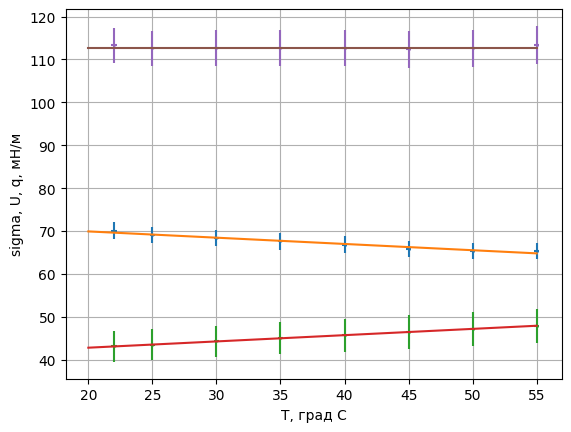

In [69]:
plt.xlabel("T, град С")
plt.ylabel("sigma, U, q, мН/м")
linearcalc_error(raschet["T"], raschet["sigma"], 20)
linearcalc_error(raschet["T"], raschet["q"], 20)
linearcalc_error(raschet["T"], raschet["U"], 20)